# Transfer Learning Part 2 : Fine Tuning

In [1]:
# Install TensorFlow 2.9.0 to avoid issues (later versions may work)
# -U stands for "update" and "-q" stands for "quiet"
import tensorflow as tf
# if tf.__version__ != "2.9.0":
#   !pip install -U -q tensorflow==2.9.0
#   import os
#   os._exit(00)
print(tf.__version__)

2.9.0


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# import helper functions
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

See how to use the pretrained models within tf.keras.applications

In [4]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Get 10% of training data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"


## OLD WAY
# Create Image data generator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

## NEW WAY
# Use image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(128,128),
                                                                 label_mode="categorical",
                                                                 batch_size=16,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(128,128),
                                                                label_mode="categorical",
                                                                batch_size=16,
                                                                shuffle=True)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


None -> batch size(doesnt show the number usually)

(224,224,3) -> height,width,colour channel

(None,10) -> None = batch size |  10 -> number of classes in label tensor

In [7]:
# Check class names of dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of a batch of data
for images,labels in train_data.take(1):
    print(images,labels)

tf.Tensor(
[[[[135.5       176.5       232.5      ]
   [139.        178.        233.       ]
   [132.        169.        222.       ]
   ...
   [ 69.5        87.5       130.       ]
   [ 74.         88.5       127.5      ]
   [ 66.5        77.5       111.5      ]]

  [[131.        172.        226.       ]
   [131.        170.        225.       ]
   [127.5       166.        218.5      ]
   ...
   [ 72.         82.        113.       ]
   [ 71.5        85.5       122.       ]
   [ 67.5        84.5       120.5      ]]

  [[146.5       185.5       240.5      ]
   [133.5       172.5       227.5      ]
   [126.        165.        220.       ]
   ...
   [211.        193.        196.       ]
   [179.        170.        178.       ]
   [125.        119.        130.       ]]

  ...

  [[219.5       175.5       146.5      ]
   [225.        182.5       154.       ]
   [222.5       181.5       152.5      ]
   ...
   [ 94.5        84.5        56.       ]
   [ 89.5        78.5        54.       ]
   [1

In [9]:
#Try building a model using tf.keras.applications
# efficient_net_model = tf.keras.models.Sequential([
#     tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(480,480,3)),
#     tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
# ])
# efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
#                             metrics=['accuracy'])
# efficientnet_history = efficient_net_model.fit(train_data,
#                                                epochs=5,
#                                                steps_per_epoch=len(train_data),
#                                                validation_data=test_data,
#                                                validation_steps=len(test_data))

### Using tf Functional model (different from Sequential model)

* Building a transfer learning model using keras Functional API
* Provides more flexibility compared to Seqquential model


In [10]:
# 1. Create a base model with tf.keras.applciations
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # include_top -> last layer (will be different for different datasets)

# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)

print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x)

print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layers")(x)

# 8. Combine input with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        verbose=1,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

shape after passing inputs through base_model: (None, 4, 4, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230629-110254
Epoch 1/5
47/47 [==============================] - 14s 91ms/step - loss: 1.7638 - accuracy: 0.4413 - val_loss: 1.2073 - val_accuracy: 0.6953
Epoch 2/5
47/47 [==============================] - 2s 47ms/step - loss: 0.9853 - accuracy: 0.7600 - val_loss: 0.8971 - val_accuracy: 0.7453
Epoch 3/5
47/47 [==============================] - 2s 46ms/step - loss: 0.7364 - accuracy: 0.8147 - val_loss: 0.7509 - val_accuracy: 0.7766
Epoch 4/5
47/47 [==============================] - 2s 45ms/step - loss: 0.6044 - accuracy: 0.8520 - val_loss: 0.6952 - val_accuracy: 0.7812
Epoch 5/5
47/47 [==============================] - 2s 44ms/step - loss: 0.5099 - accuracy: 0.8787 - val_loss: 0.6597 - val_accuracy: 0.7937


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

157/157 [==============================] - 5s 29ms/step - loss: 0.6536 - accuracy: 0.8056


[0.6536378264427185, 0.8055999875068665]

In [12]:
base_model.layers

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# Get summary of the model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# Summary of full model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 average_global_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


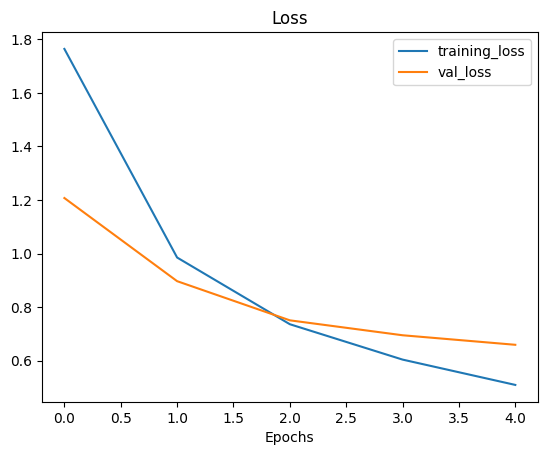

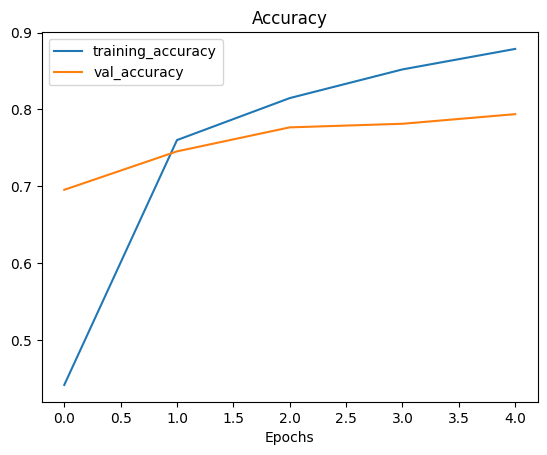

In [16]:
plot_loss_curves(history_0)

In [17]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

### Practice Functional ApI method of building the model
1. using efficientnet
2. using resnet

In [18]:
# using efficeintnet:
import tensorflow as tf
base_model_efficinetnet = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_efficinetnet.trainable=False

inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

x = base_model_efficinetnet(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layer")(x)

model_efficinetnet = tf.keras.Model(inputs,outputs)

model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

history_efficientnet = model_efficinetnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

Epoch 1/5
47/47 [==============================] - 7s 68ms/step - loss: 1.8217 - accuracy: 0.4493 - val_loss: 1.2164 - val_accuracy: 0.7266
Epoch 2/5
47/47 [==============================] - 2s 43ms/step - loss: 1.0094 - accuracy: 0.7560 - val_loss: 0.8639 - val_accuracy: 0.7828
Epoch 3/5
47/47 [==============================] - 2s 43ms/step - loss: 0.7559 - accuracy: 0.8067 - val_loss: 0.7461 - val_accuracy: 0.8016
Epoch 4/5
47/47 [==============================] - 2s 43ms/step - loss: 0.6176 - accuracy: 0.8427 - val_loss: 0.6980 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 2s 43ms/step - loss: 0.5206 - accuracy: 0.8893 - val_loss: 0.6469 - val_accuracy: 0.8094


In [19]:
model_efficinetnet.evaluate(test_data)

157/157 [==============================] - 4s 23ms/step - loss: 0.6503 - accuracy: 0.8096


[0.6503255367279053, 0.8095999956130981]

In [20]:
# ResnetV2
base_model_resnet = tf.keras.applications.ResNet50(include_top=False)

base_model_resnet.trainable=False

inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_resnet(x)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_resnet = tf.keras.Model(inputs,outputs)

model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_resnet = model_resnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

Epoch 1/5
47/47 [==============================] - 6s 77ms/step - loss: 2.3306 - accuracy: 0.0947 - val_loss: 2.3044 - val_accuracy: 0.1187
Epoch 2/5
47/47 [==============================] - 3s 54ms/step - loss: 2.3139 - accuracy: 0.0800 - val_loss: 2.2915 - val_accuracy: 0.1109
Epoch 3/5
47/47 [==============================] - 3s 54ms/step - loss: 2.3068 - accuracy: 0.0813 - val_loss: 2.2884 - val_accuracy: 0.1203
Epoch 4/5
47/47 [==============================] - 3s 54ms/step - loss: 2.2959 - accuracy: 0.1213 - val_loss: 2.2852 - val_accuracy: 0.1406
Epoch 5/5
47/47 [==============================] - 3s 54ms/step - loss: 2.2924 - accuracy: 0.1320 - val_loss: 2.2805 - val_accuracy: 0.1500


In [21]:
## EfficientNet -> practice
base_model_efficinetnet = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_efficinetnet.trainable=False
inputs = tf.keras.layers.Input(shape=(128,128,3))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
model_efficinetnet = tf.keras.Model(inputs,outputs)
model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                           metrics=["accuracy"])
history_efficientnet = model_efficinetnet.fit(train_data,
                                              epochs=8,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=(0.25*len(test_data)))

Epoch 1/8
47/47 [==============================] - 7s 64ms/step - loss: 1.5808 - accuracy: 0.5187 - val_loss: 0.9902 - val_accuracy: 0.7391
Epoch 2/8
47/47 [==============================] - 2s 43ms/step - loss: 0.8205 - accuracy: 0.7893 - val_loss: 0.7641 - val_accuracy: 0.7859
Epoch 3/8
47/47 [==============================] - 2s 43ms/step - loss: 0.6192 - accuracy: 0.8520 - val_loss: 0.6910 - val_accuracy: 0.7859
Epoch 4/8
47/47 [==============================] - 2s 43ms/step - loss: 0.4850 - accuracy: 0.8827 - val_loss: 0.6290 - val_accuracy: 0.8047
Epoch 5/8
47/47 [==============================] - 2s 43ms/step - loss: 0.4140 - accuracy: 0.9120 - val_loss: 0.5935 - val_accuracy: 0.8188
Epoch 6/8
47/47 [==============================] - 2s 43ms/step - loss: 0.3422 - accuracy: 0.9387 - val_loss: 0.5836 - val_accuracy: 0.8219
Epoch 7/8
47/47 [==============================] - 2s 42ms/step - loss: 0.2932 - accuracy: 0.9440 - val_loss: 0.5739 - val_accuracy: 0.8281
Epoch 8/8
47/47 [===

In [22]:
### Last practice with resnet and efficient -> combined
base_model_eff = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_res = tf.keras.applications.ResNet50(include_top=False)
base_model_eff_base = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_eff.trainable=False
base_model_res.trainable=False
base_model_eff_base.trainable=False

inputs = tf.keras.Input(shape=(128,128,3),
                         name="input_layer")

norm = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_eff(inputs)
y = base_model_res(norm)
z = base_model_eff_base(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
y = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(y)
z = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(z)

outputs1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
outputs2 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(y)
outputs3 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(z)

model_eff = tf.keras.Model(inputs,outputs1)
model_res = tf.keras.Model(inputs,outputs2)
model_eff_base = tf.keras.Model(inputs,outputs3)

model_eff.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_res.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_eff_base.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])

history_eff = model_eff.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_res = model_res.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_eff_base = model_eff_base.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)

model_eff.evaluate(test_data)
model_res.evaluate(test_data)
model_eff_base.evaluate(test_data)

Epoch 1/8
47/47 [==============================] - 29s 306ms/step - loss: 1.6229 - accuracy: 0.4613 - val_loss: 1.0716 - val_accuracy: 0.7016
Epoch 2/8
47/47 [==============================] - 9s 201ms/step - loss: 0.9213 - accuracy: 0.7373 - val_loss: 0.9241 - val_accuracy: 0.6953
Epoch 3/8
47/47 [==============================] - 9s 202ms/step - loss: 0.7187 - accuracy: 0.7987 - val_loss: 0.8578 - val_accuracy: 0.7094
Epoch 4/8
47/47 [==============================] - 9s 202ms/step - loss: 0.6211 - accuracy: 0.8187 - val_loss: 0.8474 - val_accuracy: 0.7141
Epoch 5/8
47/47 [==============================] - 9s 201ms/step - loss: 0.5412 - accuracy: 0.8667 - val_loss: 0.7910 - val_accuracy: 0.7500
Epoch 6/8
47/47 [==============================] - 9s 201ms/step - loss: 0.4525 - accuracy: 0.8973 - val_loss: 0.7762 - val_accuracy: 0.7469
Epoch 7/8
47/47 [==============================] - 9s 202ms/step - loss: 0.4097 - accuracy: 0.8933 - val_loss: 0.8000 - val_accuracy: 0.7391
Epoch 8/8
47

[0.5778940916061401, 0.8155999779701233]

#### Transfer learnig feature extraction

In [23]:
#1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so that the underlying pre-trained weights arents updated)
base_model.trainable=False

#3. Create inputs for model
inputs = tf.keras.Input(shape=(128,128,3),
                        name="input_layer")

#4.(optional) If using ResNet50V2 -> need to normalize the inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model
x = base_model(inputs)
print("shape after passing inputs through base model: "+str(x.shape))

#6. Average pool the outputs of the base_model(aggregate all the most important information, reduce the number of computatuions)
x = tf.keras.layers.GlobalAveragePooling2D(name="avgPool")(x)
print("shape after GlobalAveragePooling2D: "+str(x.shape))

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

#8. Combine the inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model and save the history
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

shape after passing inputs through base model: (None, 4, 4, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
47/47 [==============================] - 8s 76ms/step - loss: 1.8353 - accuracy: 0.4147 - val_loss: 1.2381 - val_accuracy: 0.7156
Epoch 2/5
47/47 [==============================] - 2s 43ms/step - loss: 1.0144 - accuracy: 0.7600 - val_loss: 0.8845 - val_accuracy: 0.7656
Epoch 3/5
47/47 [==============================] - 2s 43ms/step - loss: 0.7609 - accuracy: 0.8133 - val_loss: 0.7664 - val_accuracy: 0.7937
Epoch 4/5
47/47 [==============================] - 2s 44ms/step - loss: 0.6195 - accuracy: 0.8467 - val_loss: 0.7148 - val_accuracy: 0.7984
Epoch 5/5
47/47 [==============================] - 2s 43ms/step - loss: 0.5208 - accuracy: 0.8693 - val_loss: 0.6782 - val_accuracy: 0.8141


In [24]:
#Evaluate the model
model_1.evaluate(test_data)

157/157 [==============================] - 4s 22ms/step - loss: 0.6559 - accuracy: 0.8180


[0.6558725237846375, 0.8180000185966492]

In [25]:
# Check the layers in the base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer)

0 <keras.engine.input_layer.InputLayer object at 0x000002503368D0D0>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000025096E3EF70>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x000002511F773130>
3 <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002511A8775E0>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000025142159070>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x000002507D2D4610>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000250868CB070>
7 <keras.layers.core.activation.Activation object at 0x00000251253566A0>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x00000251421553D0>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x00000250868A7400>
10 <keras.layers.core.activation.Activation object at 0x0000025142797E20>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at

### Getting Feature vector from trained model
Let's demonstrate GlobalAveragePooling2D layer...

let us use shape=(1,4,4,3) and pass it to GlobalAveragePooling2D

In [26]:
input_shape=(1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
print("Random input tensor: \n"+str(input_tensor))

#pass the random tensor through a global average pooling layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print("\n\nAfter passing through pooling layer \n"+str(global_average_pooling_tensor))
print("\n\nShape of input tensor: "+str(input_tensor.shape))
print("\n\nShape of pooling layer: "+str(global_average_pooling_tensor.shape))

Random input tensor: 
tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)


After passing through pooling layer 
tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


Shape of input tensor: (1, 4, 4, 3)


Shape of pooling layer: (1, 3)


In [27]:
### Let's replicate globalaveragepool2D layer
tf.reduce_mean(input_tensor,axis=[1,2]) #mean along the axis 1 and 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [28]:
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [29]:
# Use GlobalMaxPool2D
print("Shape before passing:\n",input_shape)
x = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print("\nAfter passing through global max pool layer:\n",x)
print("\nshape after passing: ",x.shape)

Shape before passing:
 (1, 4, 4, 3)

After passing through global max pool layer:
 tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)

shape after passing:  (1, 3)


### Running a series of transfer learning experiments
0. model_0  -> baseline
1. use 1% data  -> model_1
2. 10% data - feature extraction with data augmentation -> model_2
3. 10% data - fine tuning with data augmentation    -> model_3
4. 100% data - fine tuning with data augmentation   -> model_4

#### MODEL1

In [30]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-06-29 11:10:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:819::2010, 2404:6800:4007:81a::2010, 2404:6800:4007:817::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:819::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: '10_food_classes_1_percent.zip.5'

     0K .......... .......... .......... .......... ..........  0%  265K 8m12s
    50K .......... .......... .......... .......... ..........  0%  262K 8m14s
   100K .......... .......... .......... .......... ..........  0% 3.24M 5m43s
   150K .......... .......... .......... .......... ..........  0% 4.52M 4m24s
   200K .......... .......... .......... .......... ..........  0% 11.9M 3m33s
   250K .......... .......... .......... .......... ..........  0% 7.08M 3m1s
   300K .......... .......... 

In [31]:
#Create training and testing dir
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [32]:
#setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=(128,128),
                                                                           batch_size=16)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(128,128),
                                                                batch_size=16)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Adding data augmentation into the model
* we can use the layers inside:
    * tf.keras.layers.experimental.preprocessing()

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    #tf.keras.layers.experimental.preprocessing.Rescale(1./255), #-> keep it for ResNetV2, efficientNet already has it
],name="data_augmentation")

10_food_classes_1_percent/train/pizza/394049.jpg


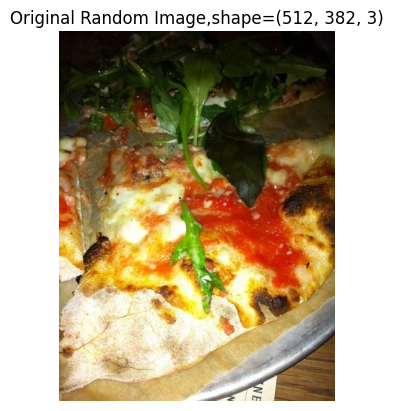

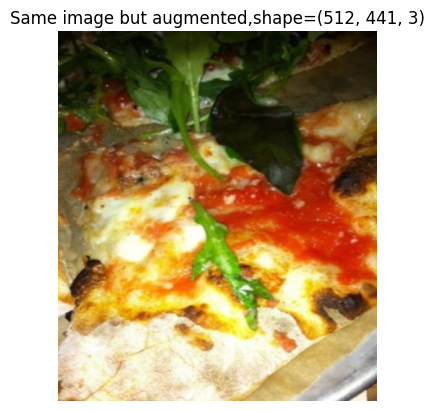

In [34]:
### Visualise the data augmentation and see what happens to the data
# View a random image and compare it with its augmentaed image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image
print(random_image_path)

#Read and plot the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original Random Image,shape={img.shape}")
plt.axis(False)
plt.show()

#Plot the augmented image
augmented_img = data_augmentation(img,training=True)
plt.imshow(augmented_img/255)   # -> clipping images -> not normalised
plt.title(f"Same image but augmented,shape={augmented_img.shape}")
plt.axis(False)
plt.show()

#print(img)

In [35]:
## model_1 : Feature extraction transfer learinng with data augmentation

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=(128,128),
                                                                           batch_size=16)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(128,128),
                                                                batch_size=16)

data_augmentation_1 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
],name="data_augmentation")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs1 = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")
#Add augmentation layer
x = data_augmentation_1(inputs1,training=True)
x = base_model(x/255,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs1=tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_1 = tf.keras.Model(inputs1,outputs1)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'],
                run_eagerly=True)
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230629-111040
Epoch 1/5
5/5 [==============================] - 9s 2s/step - loss: 2.4111 - accuracy: 0.0571 - val_loss: 2.3289 - val_accuracy: 0.0897
Epoch 2/5
5/5 [==============================] - 8s 2s/step - loss: 2.3535 - accuracy: 0.0429 - val_loss: 2.3072 - val_accuracy: 0.1010
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 2.3276 - accuracy: 0.0857 - val_loss: 2.3211 - val_accuracy: 0.0946
Epoch 4/5
5/5 [==============================] - 7s 2s/step - loss: 2.3720 - accuracy: 0.0429 - val_loss: 2.3178 - val_accuracy: 0.1058
Epoch 5/5
5/5 [==============================] - 7s 2s/step - loss: 2.3122 - accuracy: 0.1000 - val_loss: 2.3156 - val_accuracy: 0.0962


In [36]:
# Check out model summary
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, None, None, 3)    0         
 da)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [37]:
# Evaluate on full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

157/157 [==============================] - 26s 164ms/step - loss: 2.3084 - accuracy: 0.1056


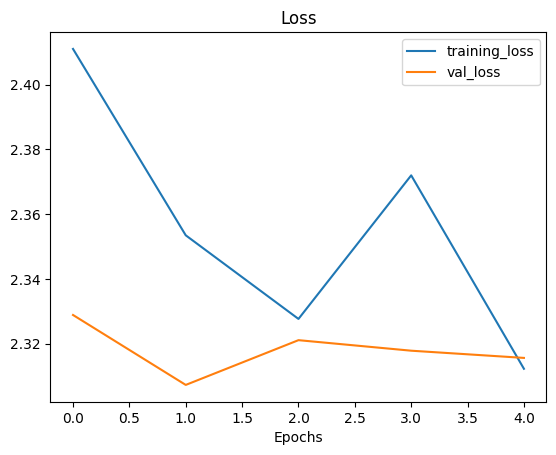

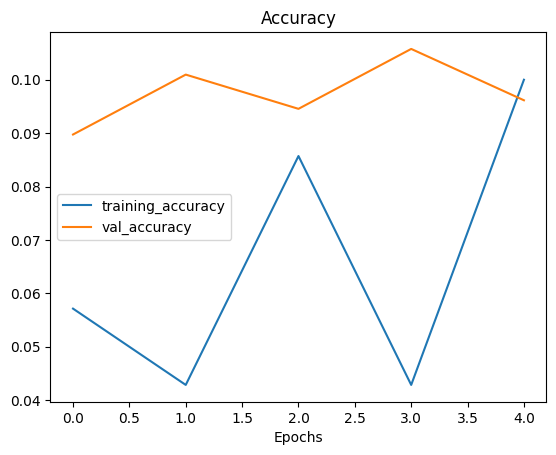

In [38]:
#Loss curves
plot_loss_curves(history_1_percent)

#### Model_2

In [39]:
### Model 2 with 10% food data, data augmentation and normal compilation with efficientNetB0 and fitting
## maintain the same test data to compare
import tensorflow as tf
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train/",
                                                                           image_size=(128,128),
                                                                           label_mode="categorical",
                                                                           batch_size=16)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_1_percent/test/",
                                                                          image_size=(128,128),
                                                                          label_mode="categorical",
                                                                          batch_size=16)

data_augmentation_10_percent = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
],name="data_augmentation_10_percent")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs_10_percent = tf.keras.layers.Input(shape=(128,128,3),
                                         name="input_layer")

x = data_augmentation_10_percent(inputs_10_percent,training=True)
x = base_model(x,training=False) # training=False because to keep the model is inference mode, so that batchnorm layer stays the same and dosen't change
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs_10_percent = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_2 = tf.keras.Model(inputs_10_percent,outputs_10_percent)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'],
               run_eagerly=True)
hisotry_10_percent = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=int(0.2*len(test_data_10_percent)))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Epoch 1/5
47/47 [==============================] - 17s 356ms/step - loss: 1.9613 - accuracy: 0.3373 - val_loss: 1.5424 - val_accuracy: 0.5746
Epoch 2/5
 1/47 [..............................] - ETA: 16s - loss: 1.5724 - accuracy: 0.5625

ResourceExhaustedError: Exception encountered when calling layer "block6d_bn" (type BatchNormalization).

OOM when allocating tensor with shape[16,4,4,1152] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

Call arguments received by layer "block6d_bn" (type BatchNormalization):
  • inputs=tf.Tensor(shape=(16, 4, 4, 1152), dtype=float32)
  • training=False

157/157 [==============================] - 25s 155ms/step - loss: 0.9874 - accuracy: 0.6876


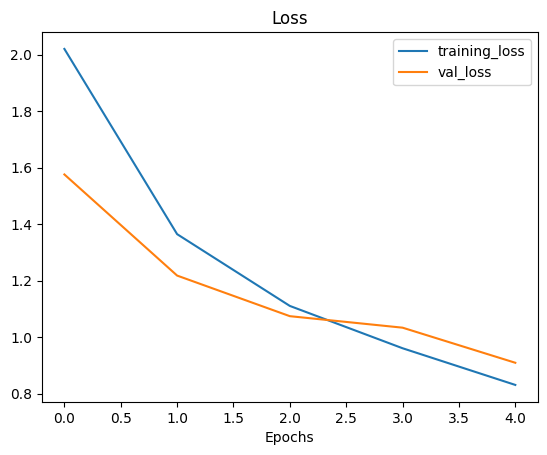

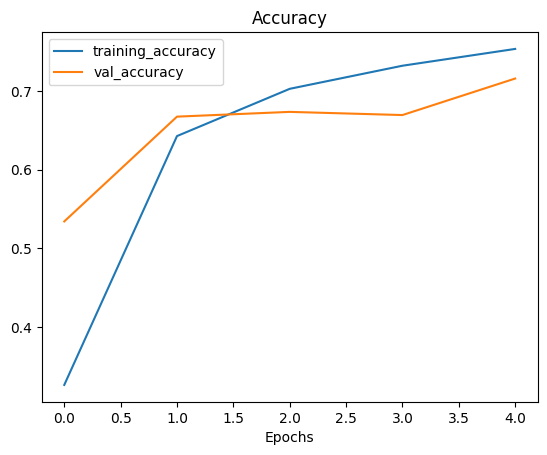

In [4]:
model_2.evaluate(test_data_10_percent)
plot_loss_curves(hisotry_10_percent)

In [5]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_percen  (None, None, None, 3)    0         
 t (Sequential)                                                  
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating a ModelCheckpoint callback
* Save the model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting
* *tf.keras.callbacks.ModelCheckpoint()*
* .ckpt -> extension

In [6]:
# Set check point path :
check_point_path = "10%_model_checkpoints_weights/save.ckpt"

# Create a model checkpoint that saves models's weight
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = check_point_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",# save every epoch,
                                                         verbose=1)

In [7]:
# Fit the model of 10% data and use the above created callback
train_data = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train",
                                                       image_size=(128,128),
                                                       batch_size=16,
                                                       label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/test",
                                                      image_size=(128,128),
                                                      batch_size=16,
                                                      label_mode="categorical")
data_augmentation_10_percent = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
],name="data_augmentation_10_percent")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs = tf.keras.Input(shape=(128,128,3))
x = data_augmentation_10_percent(inputs,training=True)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_2_checkpoint_callback = tf.keras.Model(inputs,outputs)
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                    optimizer=tf.keras.optimizers.Adam(),
                                    metrics=['accuracy'])
history_2_checkpoint_callback = model_2_checkpoint_callback.fit(train_data,
                                                                epochs=5,
                                                                steps_per_epoch=len(train_data),
                                                                validation_data = test_data,
                                                                validation_steps=int(0.25*len(test_data)),
                                                                callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback])

Found 750 files belonging to 10 classes.


Found 2500 files belonging to 10 classes.
Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230625-135303
Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 1.9879 - accuracy: 0.3107
Epoch 1: saving model to 10%_model_checkpoints_weights\save.ckpt
47/47 [==============================] - 22s 372ms/step - loss: 1.9879 - accuracy: 0.3107 - val_loss: 1.6127 - val_accuracy: 0.5080
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.6387
Epoch 2: saving model to 10%_model_checkpoints_weights\save.ckpt
47/47 [==============================] - 10s 221ms/step - loss: 1.3312 - accuracy: 0.6387 - val_loss: 1.2561 - val_accuracy: 0.6554
Epoch 3/5
47/47 [==============================] - ETA: 0s - loss: 1.0909 - accuracy: 0.7053
Epoch 3: saving model to 10%_model_checkpoints_weights\save.ckpt
47/47 [==============================] - 8s 177ms/step - loss: 1.0909 - accuracy: 0.7053 - val_loss: 1.1394 - val_accuracy: 0.6635
Ep

In [8]:
model_0.evaluate(test_data)

NameError: name 'model_0' is not defined

In [9]:
before_saving = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 11s 70ms/step - loss: 0.9844 - accuracy: 0.6928


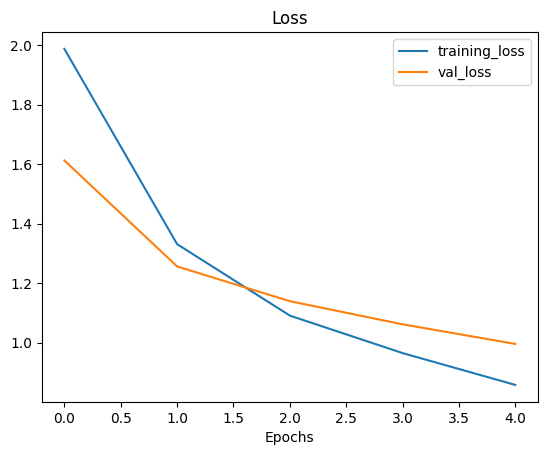

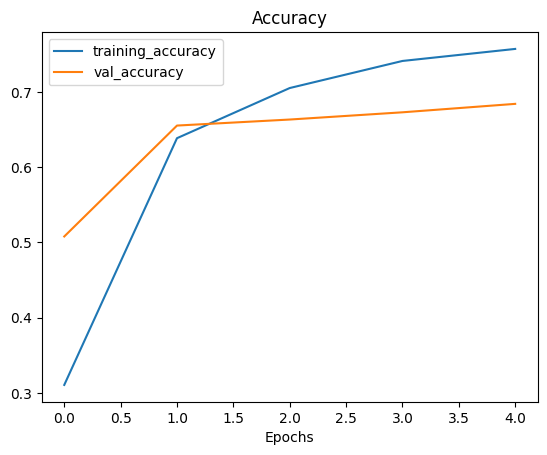

In [10]:
#Plot loss curves
plot_loss_curves(history_2_checkpoint_callback)

### Loading in checkpointed weights
Loading in cehckpointed weights returns a model to specific checkpoint

In [11]:
# Load the model
model_2_checkpoint_callback.load_weights(check_point_path)

In [12]:
#Evaluate model_2 with loaded weights
after_loading = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 10s 61ms/step - loss: 1.0018 - accuracy: 0.6948


In [13]:
after_loading == before_saving

False

It says false because of change in precision points depends on the way they are stored in the system

In [14]:
# Check to see if loaded model results are same as before saving model resutls
import numpy as np
np.isclose(np.array(after_loading),np.array(before_saving)) # it is same, but there is minor changes due to how it is stored

array([False, False])

In [15]:
# Check the difference between two results:
np.array(after_loading) - np.array(before_saving)

array([0.0173189 , 0.00200003])

#### MODEL 3
Fine tuning: some layers can be unfrozen in the imported model to improve model learning the patterns

In [16]:
# Use 10% data
model_2.layers

In [17]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_percen  (None, None, None, 3)    0         
 t (Sequential)                                                  
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [18]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000258F4C6D070> True
<keras.engine.sequential.Sequential object at 0x00000258865E68B0> True
<keras.engine.functional.Functional object at 0x000002589CB68910> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000025896516A30> True
<keras.layers.core.dense.Dense object at 0x00000258964B17C0> True


In [19]:
# What layers are there in base_model:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
print(len(model_2.layers[2].trainable_variables))

0


In [21]:
# To begin fine tuning, lets start by setting last 10 layers of base model trainable to true
#base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile the entire model everytime there is a change
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate by 10 times so taht new unfrozen layers dosen't learn too much and become useless
                metrics=['accuracy'])


In [22]:
# Check for layers thats are trainabale
for i, layer in enumerate(model_2_checkpoint_callback.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [23]:
print(len(model_2_checkpoint_callback.trainable_variables))

12


In [24]:
model_2_checkpoint_callback.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [25]:
#Fine tune it for another 5 epochs
history_2_fine_tune = model_2_checkpoint_callback.fit(train_data,
                                                      epochs=10,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.25*len(test_data)),
                                                      steps_per_epoch=len(train_data),
                                                      initial_epoch=history_2_checkpoint_callback.epoch[-1], # start training from previous last epoch
                                                      callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230625-135430
Epoch 5/10


47/47 [==============================] - 13s 169ms/step - loss: 0.7460 - accuracy: 0.7747 - val_loss: 0.9140 - val_accuracy: 0.6827
Epoch 6/10
47/47 [==============================] - 5s 111ms/step - loss: 0.5837 - accuracy: 0.8160 - val_loss: 0.8782 - val_accuracy: 0.7003
Epoch 7/10
47/47 [==============================] - 5s 97ms/step - loss: 0.5003 - accuracy: 0.8360 - val_loss: 0.9041 - val_accuracy: 0.6971
Epoch 8/10
47/47 [==============================] - 5s 101ms/step - loss: 0.4899 - accuracy: 0.8547 - val_loss: 0.9395 - val_accuracy: 0.7163
Epoch 9/10
47/47 [==============================] - 4s 96ms/step - loss: 0.4602 - accuracy: 0.8653 - val_loss: 0.9441 - val_accuracy: 0.7051
Epoch 10/10
47/47 [==============================] - 4s 86ms/step - loss: 0.4413 - accuracy: 0.8547 - val_loss: 0.9134 - val_accuracy: 0.6971


In [26]:
# EValuate the model
fine_tune_result = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 8s 48ms/step - loss: 0.8739 - accuracy: 0.7112


In [27]:
after_loading,fine_tune_result

([1.0017503499984741, 0.6948000192642212],
 [0.8739489316940308, 0.7111999988555908])

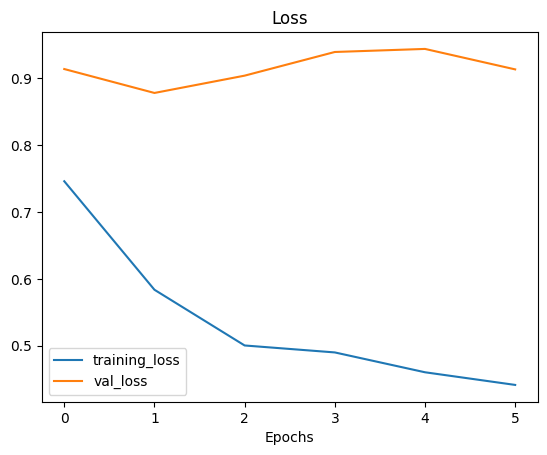

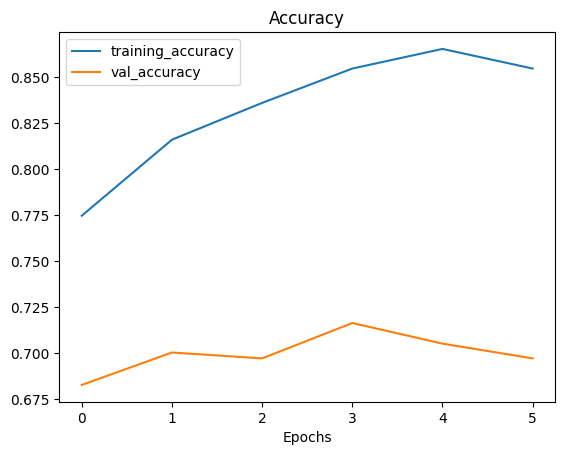

In [28]:
#Check loss curves
plot_loss_curves(history_2_fine_tune)

In [29]:
# Create function to create loss curves before and after fine tuning
def compare_history(original,final,initial_epoch=5):
  acc = original.history["accuracy"]
  loss=original.history["loss"]

  val_acc = original.history["val_accuracy"]
  val_loss=original.history["val_loss"]

  total_acc = acc + final.history["accuracy"]
  total_loss = loss + final.history["loss"]

  total_val_acc = val_acc + final.history["val_accuracy"]
  total_val_loss = val_loss + final.history["val_loss"]

  plt.figure(figsize=(8,4))
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc, label="Val accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.show()
  plt.figure(figsize=(8,4))
  plt.title('Training and Validation Accuracy')
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epoch-1, initial_epoch-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


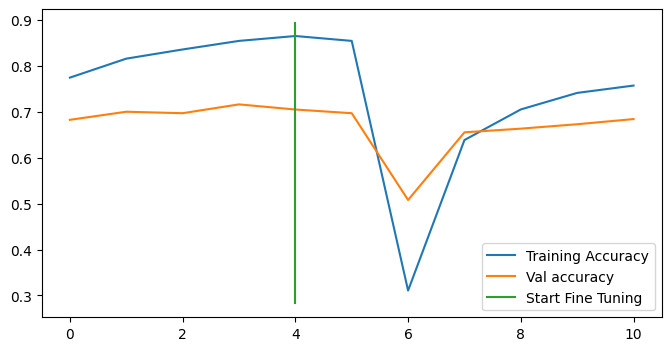

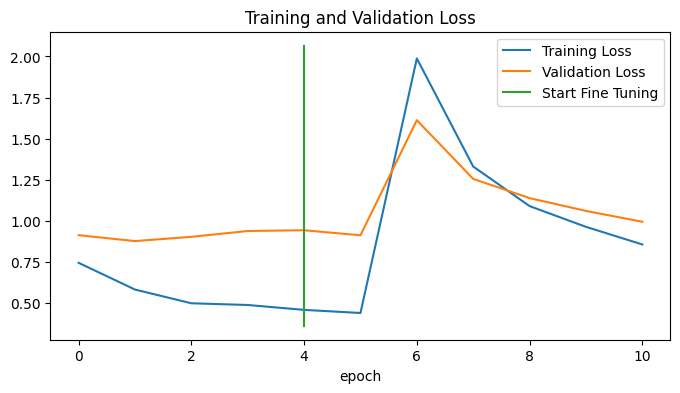

In [31]:
import matplotlib.pyplot as plt
compare_history(history_2_fine_tune,history_2_checkpoint_callback)

#### MODEL 4
100% data

In [32]:
#Download and unzipt the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-06-25 13:56:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:815::2010, 2404:6800:4007:816::2010, 2404:6800:4007:804::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:815::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip.2'

     0K .......... .......... .......... .......... ..........  0%  159K 53m1s
    50K .......... .......... .......... .......... ..........  0%  214K 46m17s
   100K .......... .......... .......... .......... ..........  0%  500K 36m29s
   150K .......... .......... .......... .......... ..........  0%  703K 30m22s
   200K .......... .......... .......... .......... ..........  0%  667K 26m49s
   250K .......... .......... .......... .......... ..........  0%  847K 24m0s
   300K .......... ........

In [33]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [34]:
train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/train",
                                                              image_size=(224,224),
                                                              label_mode="categorical",
                                                              batch_size=32)
test_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/test",
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# Evaluate model3 -> fine tuned model
model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 7s 46ms/step - loss: 0.8661 - accuracy: 0.7248


[0.8660798072814941, 0.7247999906539917]

In [36]:
fine_tune_result

[0.8739489316940308, 0.7111999988555908]

To train a fine tuning model (model_4), we need to revert model_2 back to its feature extraction weights

In [37]:
model_2_checkpoint_callback.evaluate(test_data)

  1/157 [..............................] - ETA: 19s - loss: 1.1269 - accuracy: 0.6250

157/157 [==============================] - 7s 44ms/step - loss: 0.8721 - accuracy: 0.7128


[0.8721458911895752, 0.7128000259399414]

In [38]:
before_saving

[0.9844314455986023, 0.692799985408783]

In [39]:
model_2_checkpoint_callback.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_percen  (None, None, None, 3)    0         
 t (Sequential)                                                  
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [40]:
#Load weights from check point
model_2_checkpoint_callback.load_weights(check_point_path)

In [41]:
for i, layer in enumerate(model_2_checkpoint_callback.layers):
  print(1,layer.name,layer.trainable) # Even if single layer is trainable in a big series of layers, whole series is considered trainable

1 input_3 True
1 data_augmentation_10_percent True
1 efficientnetb0 True
1 global_average_pooling2d_1 True
1 dense_1 True


In [42]:
for i, layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [43]:
history_2_checkpoint_callback.epoch

[0, 1, 2, 3, 4]

In [44]:
#Compile
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    metrics=['accuracy'])
history_100_percent_data = model_2_checkpoint_callback.fit(train_data_100_percent,
                                                           epochs=10,
                                                           initial_epoch=history_2_checkpoint_callback.epoch[-1],
                                                           steps_per_epoch=len(train_data_100_percent),
                                                           validation_data=test_data_100_percent,
                                                           validation_steps=int(0.25*len(test_data_100_percent)),
                                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230625-135754
Epoch 5/10


ValueError: in user code:

    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 224, 224, 3)


In [ ]:
#Evaluate on whole test data
finetune_full_data = model_2_checkpoint_callback.evaluate(test_data_100_percent)
finetune_full_data

79/79 [==============================] - 13s 154ms/step - loss: 0.3209 - accuracy: 0.8984


[0.3209095597267151, 0.8984000086784363]

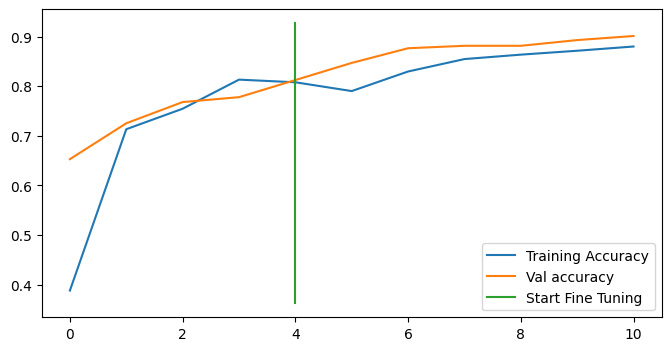

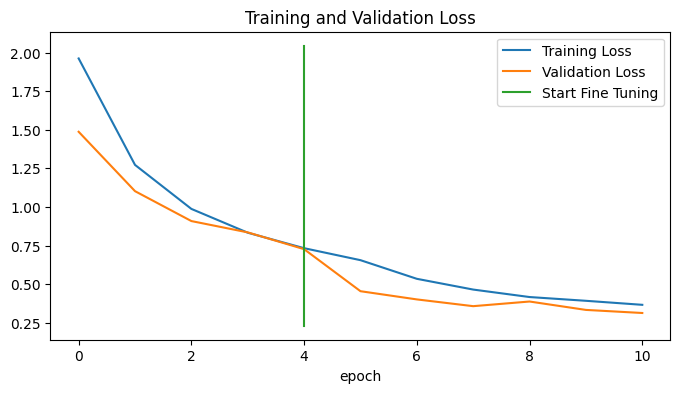

In [ ]:
compare_history(history_2_checkpoint_callback,history_100_percent_data)

## Viewing experiment on tensorboard

In [ ]:
## Viewing experiment on tensorboard
#View logs
# upload record
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments with 10 Food101 classes" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine tuning" \
#   --one_shot #Exits the uplaoder once its finished

#Challenge:
**Recreate one of the experiments we did with the EfficientNetB4 architecture in the tf.keras.applications module.**

* Create basic model and check with/without data augmentation
* Fine tune that model on full dataset

In [45]:
from tensorflow.python import training
# Baseic model
train_data_100_challenge = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/train",
                                                                               batch_size=32,
                                                                               image_size=(224,224),
                                                                               label_mode="categorical",
                                                                               shuffle=True)
test_data_100_challenge = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/test",
                                                                              batch_size=32,
                                                                              image_size=(224,224),
                                                                              label_mode="categorical",
                                                                              shuffle=True)

initial_epoch = 5

data_aug_challenge = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
],name="data_aug_challenge")

base_model_challenge = tf.keras.applications.EfficientNetB4(include_top=False)
base_model_challenge.trainable=False

inputs = tf.keras.Input(shape=(224,224,3),
                        name="input_layer_challenge")

x1 = base_model_challenge(inputs)
x2 = data_aug_challenge(inputs,training=True)

x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

x2 = base_model_challenge(x2,training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

outputs1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x1)
outputs2 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x2)

model_challenge_no_aug = tf.keras.Model(inputs,outputs1)
model_challenge_aug = tf.keras.Model(inputs,outputs2)

model_challenge_no_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(),
                               metrics=['accuracy'])
print("Running model without data augmentation and using model checkpoint")
history_challenge_no_aug = model_challenge_no_aug.fit(train_data_100_challenge,
                                                      epochs=initial_epoch,
                                                      steps_per_epoch=len(train_data_100_challenge),
                                                      validation_data=test_data_100_challenge,
                                                      validation_steps=int(0.25*len(test_data_100_challenge)),
                                                      callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="ChallengeQuesion/noAug",
                                                                                                    save_best_only=False,
                                                                                                    save_weights_only=True,
                                                                                                    save_freq="epoch")])

print("Running model with data augmentation and using model checkpoint")
model_challenge_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])
history_challenge_aug = model_challenge_aug.fit(train_data_100_challenge,
                                                epochs=initial_epoch,
                                                steps_per_epoch=len(train_data_100_challenge),
                                                validation_data=test_data_100_challenge,
                                                validation_steps=int(0.25*len(test_data_100_challenge)),
                                                callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="ChallengeQuesion/Aug",
                                                                                              save_best_only=False,
                                                                                              save_weights_only=True,
                                                                                              save_freq="epoch")])

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
71686520/71686520 [==============================] - 9s 0us/step
Running model without data augmentation and using model checkpoint
Epoch 1/5
235/235 [==============================] - 68s 245ms/step - loss: 0.7800 - accuracy: 0.7744 - val_loss: 0.4043 - val_accuracy: 0.8701
Epoch 2/5
235/235 [==============================] - 55s 234ms/step - loss: 0.4722 - accuracy: 0.8533 - val_loss: 0.3364 - val_accuracy: 0.8882
Epoch 3/5
235/235 [==============================] - 54s 229ms/step - loss: 0.4143 - accuracy: 0.8687 - val_loss: 0.2937 - val_accuracy: 0.9046
Epoch 4/5
235/235 [==============================] - 54s 230ms/step - loss: 0.3706 - accuracy: 0.8841 - val_loss: 0.3000 - val_accuracy: 0.9013
Epoch 5/5
235/235 [==============================] - 54s 231ms/step - loss: 0.3427 - accuracy: 0.8932 - val_loss: 0.2946 - val_accuracy: 0.9030
Running model with data augmentation and using model checkpoint


In [46]:
print(model_challenge_no_aug.evaluate(test_data_100_challenge))
print(model_challenge_aug.evaluate(test_data_100_challenge))

79/79 [==============================] - 17s 217ms/step - loss: 0.2950 - accuracy: 0.9064
[0.29502570629119873, 0.9064000248908997]
79/79 [==============================] - 27s 344ms/step - loss: 0.4389 - accuracy: 0.8632
[0.4389346241950989, 0.8632000088691711]


Model without data augmentation did better
Use the model that didnt undergo data augmentation for fine tuning and train it on full data

In [47]:
model_challenge_no_aug.load_weights("ChallengeQuesion/noAug")
model_challenge_no_aug.evaluate(test_data_100_challenge)

79/79 [==============================] - 17s 206ms/step - loss: 0.2950 - accuracy: 0.9064


[0.29502469301223755, 0.9064000248908997]

In [48]:
base_model_challenge.trainable=True
for layer in base_model_challenge.layers[:-10]:
  layer.tranable=False

#Recompile
model_challenge_no_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                               metrics=['accuracy'])
history_finetune_challenge = model_challenge_no_aug.fit(train_data_100_challenge,
                                                        epochs=initial_epoch+5,
                                                        steps_per_epoch=len(train_data_100_challenge),
                                                        initial_epoch = history_challenge_no_aug.epoch[-1],
                                                        validation_data=test_data_100_challenge,
                                                        validation_steps=int(0.25*len(test_data_100_challenge)))

Epoch 5/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/efficientnetb4/block2a_expand_activation/Sigmoid' defined at (most recent call last):
    File "c:\ProgramData\miniconda3\envs\TF\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\miniconda3\envs\TF\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\miniconda3\envs\TF\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\miniconda3\envs\TF\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\miniconda3\envs\TF\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ujjwa\AppData\Local\Temp\ipykernel_6892\2550985080.py", line 9, in <module>
      history_finetune_challenge = model_challenge_no_aug.fit(train_data_100_challenge,
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "c:\ProgramData\miniconda3\envs\TF\lib\site-packages\keras\activations.py", line 270, in swish
      return tf.nn.silu(x)
Node: 'model_2/efficientnetb4/block2a_expand_activation/Sigmoid'
failed to allocate memory
	 [[{{node model_2/efficientnetb4/block2a_expand_activation/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2180575]

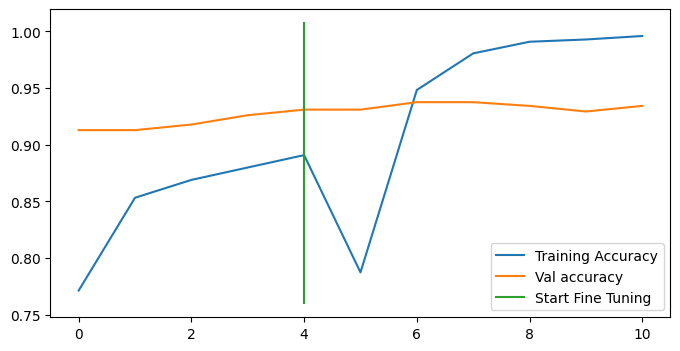

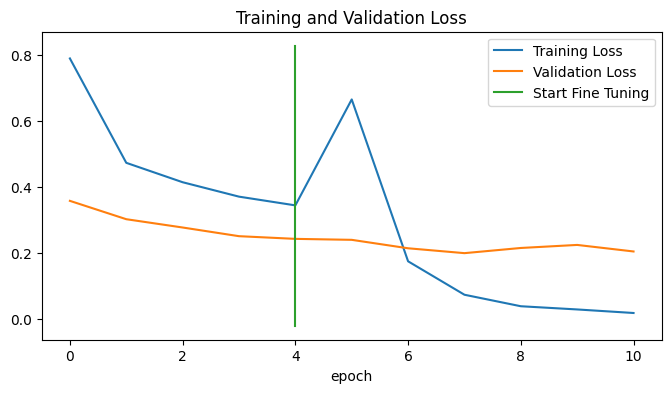

In [ ]:
compare_history(history_challenge_no_aug,history_finetune_challenge)

# EXERCISE
🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises
1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
# 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train",
                                                                            batch_size=32,
                                                                            label_mode="categorical",
                                                                            shuffle=True,
                                                                            image_size=(224,224))
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/test",
                                                                           batch_size=32,
                                                                           label_mode="categorical",
                                                                           shuffle=True,
                                                                           image_size=(224,224))

base_model_10_percent = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x =base_model_10_percent(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
model_10_percent = tf.keras.Model(inputs,outputs)
model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_10_percent = model_10_percent.fit(train_data_10_percent,
                                          epochs=10,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data_10_percent,
                                          validation_steps=int(0.25*len(test_data_10_percent)),
                                          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="Exercise1/save.ckpt",
                                                                                        save_weights_only=True,
                                                                                        save_freq="epoch",
                                                                                        save_best_only=False)])

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Epoch 1/10
24/24 [==============================] - 23s 533ms/step - loss: 1.3201 - accuracy: 0.5760 - val_loss: 1.1132 - val_accuracy: 0.6546
Epoch 2/10
24/24 [==============================] - 11s 409ms/step - loss: 0.3274 - accuracy: 0.9173 - val_loss: 1.1763 - val_accuracy: 0.6727
Epoch 3/10
24/24 [==============================] - 11s 460ms/step - loss: 0.1027 - accuracy: 0.9773 - val_loss: 0.9857 - val_accuracy: 0.7714
Epoch 4/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0381 - accuracy: 0.9907 - val_loss: 1.2374 - val_accuracy: 0.7237
Epoch 5/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0489 - accuracy: 0.9840 - val_loss: 0.9272 - val_accuracy: 0.7615
Epoch 6/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0422 - accuracy: 0.9893 - val_loss: 1.0858 - val_accuracy: 0.7664
Epoch 7/10
24/24 [==============================] - 10s 415

In [ ]:
initial_epoch=10
base_result = model_10_percent.evaluate(test_data_10_percent)
base_result

79/79 [==============================] - 8s 102ms/step - loss: 1.1720 - accuracy: 0.7076


[1.171953558921814, 0.7075999975204468]

In [ ]:
# 2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs.
base_model_10_percent.trainable=True
for layer in base_model_10_percent.layers[:-20]:
  layer.trainable=False

model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_20_finetune = model_10_percent.fit(train_data_10_percent,
                                           epochs=initial_epoch+10,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data_10_percent,
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           initial_epoch=history_10_percent.epoch[-1])

Epoch 10/20
24/24 [==============================] - 12s 213ms/step - loss: 0.1044 - accuracy: 0.9667 - val_loss: 1.1471 - val_accuracy: 0.7451
Epoch 11/20
24/24 [==============================] - 6s 226ms/step - loss: 0.0472 - accuracy: 0.9813 - val_loss: 1.0151 - val_accuracy: 0.7895
Epoch 12/20
24/24 [==============================] - 4s 155ms/step - loss: 0.0380 - accuracy: 0.9893 - val_loss: 0.9497 - val_accuracy: 0.7796
Epoch 13/20
24/24 [==============================] - 6s 227ms/step - loss: 0.0203 - accuracy: 0.9960 - val_loss: 0.9259 - val_accuracy: 0.7878
Epoch 14/20
24/24 [==============================] - 4s 153ms/step - loss: 0.0215 - accuracy: 0.9947 - val_loss: 0.9701 - val_accuracy: 0.7878
Epoch 15/20
24/24 [==============================] - 6s 224ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 1.0041 - val_accuracy: 0.7714
Epoch 16/20
24/24 [==============================] - 4s 153ms/step - loss: 0.0224 - accuracy: 0.9933 - val_loss: 0.9455 - val_accuracy: 0.769

In [ ]:
finetune_20 = model_10_percent.evaluate(test_data_10_percent)
finetune_20

79/79 [==============================] - 9s 111ms/step - loss: 0.9220 - accuracy: 0.8232


[0.9220377802848816, 0.823199987411499]

In [ ]:
# 3.Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs.
model_10_percent.load_weights("Exercise1/save.ckpt")
model_10_percent.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 71ms/step - loss: 1.1720 - accuracy: 0.7076


[1.171953558921814, 0.7075999975204468]

In [ ]:
base_result

[1.171953558921814, 0.7075999975204468]

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-30]:
  layer.trainable=False

model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_30_finetune = model_10_percent.fit(train_data_10_percent,
                                           epochs=initial_epoch+10,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data_10_percent,
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           initial_epoch=history_10_percent.epoch[-1])

Epoch 10/20
24/24 [==============================] - 12s 211ms/step - loss: 0.1349 - accuracy: 0.9667 - val_loss: 0.9766 - val_accuracy: 0.7632
Epoch 11/20
24/24 [==============================] - 4s 150ms/step - loss: 0.0512 - accuracy: 0.9853 - val_loss: 1.1025 - val_accuracy: 0.7714
Epoch 12/20
24/24 [==============================] - 6s 235ms/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 1.0768 - val_accuracy: 0.7780
Epoch 13/20
24/24 [==============================] - 6s 215ms/step - loss: 0.0166 - accuracy: 0.9933 - val_loss: 0.9280 - val_accuracy: 0.7993
Epoch 14/20
24/24 [==============================] - 7s 229ms/step - loss: 0.0215 - accuracy: 0.9907 - val_loss: 0.9320 - val_accuracy: 0.7911
Epoch 15/20
24/24 [==============================] - 4s 150ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 1.0339 - val_accuracy: 0.7812
Epoch 16/20
24/24 [==============================] - 4s 153ms/step - loss: 0.0348 - accuracy: 0.9893 - val_loss: 1.0454 - val_accuracy: 0.778

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
import os
s = "10_food_classes_all_data/train/pizza"
type(os.listdir(s))

list

In [ ]:
# 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
def visualise_and_predict(model,dataset="10_food_classes_all_data/"):
  import random as r
  import matplotlib.pyplot as plt
  import os
  #Visualising part
  x = ["train","test"]
  choice_folder = r.choice(x)
  path = dataset+choice_folder
  data = tf.keras.preprocessing.image_dataset_from_directory(path,
                                                             batch_size=32,
                                                             image_size=(224,224),
                                                             shuffle=True,
                                                             label_mode="categorical")
  print("Available classes : ",data.class_names)
  l = data.class_names
  class_choice = r.choice(l)
  print("\nClass of image being shown: ",class_choice)
  image_path = path+"/"+class_choice+"/"
  img_choice = r.choice(os.listdir(image_path))
  image = plt.imread(image_path+img_choice)
  plt.imshow(image)
  plt.show()

  #Predicting part
  image = tf.image.resize(image,(224,224))
  print("Model prediciton: ")
  ans = model.predict(tf.expand_dims(image,axis=0))
  index = tf.argmax(ans[0])
  print("The model provided, predited the above image to be :",data.class_names[index])
  print("Prediction percentage :",ans[0][index]*100,"%")

Found 2500 files belonging to 10 classes.
Available classes :  ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

Class of image being shown:  ice_cream


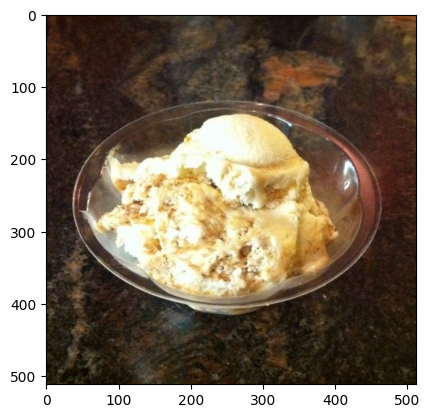

Model prediciton: 
1/1 [==============================] - 0s 45ms/step
The model provided, predited the above image to be : ice_cream
Prediction percentage : 98.58435988426208 %


In [ ]:
visualise_and_predict(model_challenge_no_aug)